In [1]:
#!pip install -r requirements.txt

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from math import sqrt
import warnings

from scipy.stats import norm
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

from sklearn.metrics import silhouette_score

In [3]:
# Ignore runtime warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Wine data

In [4]:
df_wine = pd.read_csv('data/wine.data', on_bad_lines='skip', sep=',')

In [5]:
headers_wine = ['title', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']
df_wine.columns = headers_wine

In [6]:
selected_columns_wine = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']

# Iris data

In [7]:
df_iris = pd.read_csv('data/iris.data', on_bad_lines='skip', sep=',')

In [8]:
headers_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len', 'class']
df_iris.columns = headers_iris

In [9]:
selected_columns_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len']

In [10]:
df_iris = df_iris.replace("Iris-setosa", 1)
df_iris = df_iris.replace("Iris-versicolour", 2)
df_iris = df_iris.replace("Iris-virginica", 3)

# Landsat data

In [11]:
df_landsat = pd.read_csv('data/landsat.tst', on_bad_lines='skip', sep=' ')

In [12]:
headers_landsat = [i for i in range(37)]
df_landsat.columns = headers_landsat

In [13]:
selected_columns_landsat = headers_landsat[:36]

# Magic data

In [14]:
df_magic = pd.read_csv('data/magic.data', on_bad_lines='skip', sep=',')

In [15]:
headers_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df_magic.columns = headers_magic

In [16]:
selected_columns_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

# Glass data

In [17]:
df_glass = pd.read_csv('data/glass.data', on_bad_lines='skip', sep=',')

In [18]:
headers_glass = ['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class']
df_glass.columns = headers_glass

In [19]:
selected_columns_glass = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# Standart scaler

In [20]:
X_wine = df_wine[selected_columns_wine]
X_iris = df_iris[selected_columns_iris]
X_landsat = df_landsat[selected_columns_landsat]
X_magic = df_magic[selected_columns_magic]
X_glass = df_glass[selected_columns_glass]

In [21]:
scaler = StandardScaler()

In [22]:
X_wine = scaler.fit_transform(X_wine)
X_iris = scaler.fit_transform(X_iris)
X_landsat = scaler.fit_transform(X_landsat)
X_magic = scaler.fit_transform(X_magic)
X_glass = scaler.fit_transform(X_glass)

# **HSE "Sequence-based analysis of iterative anomalous clusters"**

In [23]:
def dist(p1, p2):
    return sum((p1[i] - p2[i])**2 for i in range(len(p1)))

def farthest_point(df):
    origin = [0] * (df.shape[1])
    dists = []
    for i in range(df.shape[0]):
        dists.append([list(df.iloc[i]), dist(list(df.iloc[i]), origin)])
    dists.sort(key=lambda x: x[1], reverse=True)
    return dists[0][0]

def anom_clust(df, origin):
    if origin == '0':
        origin = [0] * (df.shape[1])
    else:
        origin = list(df.mean())
    c = farthest_point(df)
    cluster = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currpoint = list(df.iloc[i])
            if dist(currpoint, c) < dist(currpoint, origin):
                cluster[i] = 1
        cnew = []
        for i in df.columns:
            cnew.append(df.loc[(cluster == 1).values][i].mean())
        if c == cnew:
            break
        c = cnew
        cluster = pd.Series(index=range(df.shape[0]))
    return cluster, c

def BatchK_Means(df, centers):
    clusters = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currentity = list(df.iloc[i])
            dists = []
            for j in range(len(centers)):  
                dists.append([j, dist(currentity, centers[j])])
            dists.sort(key=lambda x: x[1])
            clusters[i] = dists[0][0]
        cnew = [0] * len(centers)
        for i in range(len(cnew)):
            newcenter = []
            for j in df.columns:
                newcenter.append(df.loc[(clusters == i).values][j].mean())
            cnew[i] = newcenter
        if centers == cnew:
            break
        centers = cnew
        clusters = pd.Series(index=range(df.shape[0]))
    return clusters, centers
    

def IK_Means(df, origin):
    I = df
    t = 1
    k = 1
    anom_clusters = []
    centers = []
    while not I.empty:
        S, c = anom_clust(I, origin)
        I = pd.concat([I, I.iloc[(S == 1).values]]).drop_duplicates(keep=False)
        k += 1
#         print(sum(S), c)
        if S.sum() > t:
            anom_clusters.append([S, c])
    anom_clusters.sort(key=lambda x: x[0].sum(), reverse=True)
    centers = [anom_clusters[0][1]]
    for i in range(1, len(anom_clusters)):
        if anom_clusters[i][0].sum() > anom_clusters[i - 1][0].sum() * 0.6:
            centers.append(anom_clusters[i][1])
    return BatchK_Means(df, centers)

def anom_res(X, name):
    anomwine, anomwinecent = IK_Means(X, "0")
    return f"Optimal number of clusters for {name} is: {len(pd.unique(anomwine))}"

In [24]:
X_wine_df = pd.DataFrame(X_wine)
X_iris_df = pd.DataFrame(X_iris)
X_landsat_df = pd.DataFrame(X_landsat)
X_magic_df = pd.DataFrame(X_magic)
X_glass_df = pd.DataFrame(X_glass)

print(anom_res(X_wine_df, 'wine'))
print(anom_res(X_iris_df, 'iris'))
print(anom_res(X_landsat_df, 'landsat'))
print(anom_res(X_magic_df, 'magic'))
print(anom_res(X_glass_df, 'glass'))

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empt

Optimal number of clusters for wine is: 7
Optimal number of clusters for iris is: 3


/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for e

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for e

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for e

Optimal number of clusters for landsat is: 14


/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empt

/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for e

Optimal number of clusters for magic is: 6


/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cluster = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:30: FutureWarning: The default dtype for empt

Optimal number of clusters for glass is: 8


/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))
/var/folders/2s/3p893_4d5lx_7jjv9b9x4v9h0000gn/T/ipykernel_12052/3277860180.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clusters = pd.Series(index=range(df.shape[0]))


# Determine Cluster Number Without Clustering for Every K Based on Ratio of Variance to Range in K-Means

In [25]:
def clustering_with_dwr(Y):
    # Compute the maximum number of clusters for KMeans
    max_clusters = int(sqrt(Y.shape[0] / 2))
    
    distortions = [] # Store distortions for each different number of clusters
    for i in range(1, max_clusters + 1):
        # Apply KMeans with different numbers of clusters
        kmeans = KMeans(n_clusters=i, n_init=10).fit(Y)
        # Append distortions (inertia_)
        distortions.append(kmeans.inertia_)
    
    # Find the optimal number of clusters using the "elbow point" of the distortion graph
    K_star = find_elbow_point(np.array(distortions))
    
    # Apply the clustering algorithm again with the optimal number of clusters
    kmeans = KMeans(n_clusters=K_star, n_init=10).fit(Y)
    C_star = kmeans.labels_
    
    return K_star, C_star

def find_elbow_point(G):
    # This function finds the point of maximum curvature from the line defined by the first and last points.
    n_points = len(G)
    coords = np.vstack((range(n_points), G)).T
    first_point = coords[0]
    line = np.subtract(coords[-1], first_point)
    line_norm = line / np.sqrt(np.sum(line**2))
    vec_from_first = np.subtract(coords, first_point)
    scalar_product = np.sum(vec_from_first * np.tile(line_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_norm)
    vector_to_line = np.subtract(vec_from_first, vec_from_first_parallel)
    dist_to_line = np.sqrt(np.sum(vector_to_line ** 2, axis=1))
    idx_of_elbow = np.argmax(dist_to_line)
    return idx_of_elbow + 1

In [26]:
K_star, C_star = clustering_with_dwr(X_wine)
print("Optimal number of clusters wine:", K_star)

K_star, C_star = clustering_with_dwr(X_iris)
print("Optimal number of clusters iris:", K_star)

K_star, C_star = clustering_with_dwr(X_landsat)
print("Optimal number of clusters landsat:", K_star)

K_star, C_star = clustering_with_dwr(X_magic)
print("Optimal number of clusters magic:", K_star)

K_star, C_star = clustering_with_dwr(X_glass)
print("Optimal number of clusters glass:", K_star)

Optimal number of clusters wine: 3
Optimal number of clusters iris: 2
Optimal number of clusters landsat: 6
Optimal number of clusters magic: 13
Optimal number of clusters glass: 4


# Gausian Likelyhood Score Method


In [27]:
def gaussian_likelihood_score(points, labels, resolution=50, pca=True):
    probability = 0
    n_clusters = len(np.unique(labels))
    for j in range(n_clusters):
        cluster_points = points[labels == j]
        if pca:
            cluster_points = PCA(1).fit_transform(cluster_points)
            centroid = np.mean(cluster_points)
            spread = np.std(cluster_points)

            rv = norm(loc=centroid, scale=spread)
            hist, bins = np.histogram(cluster_points[:, 0], bins=resolution)
            probability_pca = np.sum(rv.logpdf(bins[:-1]) * hist)
            if np.isnan(probability_pca):
                probability_pca = 0.
            probability += probability_pca
        else:
            centroid = np.mean(cluster_points, axis=0)
            spread = np.std(cluster_points, axis=0)

            rv_1 = norm(loc=centroid[0], scale=spread[0])
            rv_2 = norm(loc=centroid[1], scale=spread[1])

            hist_1, bins_1 = np.histogram(
                cluster_points[:, 0], bins=resolution)
            hist_2, bins_2 = np.histogram(
                cluster_points[:, 1], bins=resolution)

            probability_axis_1 = np.sum(rv_1.logpdf(bins_1[:-1]) * hist_1)
            if np.isnan(probability_axis_1):
                probability_axis_1 = 0.
            probability_axis_2 = np.sum(rv_2.logpdf(bins_2[:-1]) * hist_2)
            if np.isnan(probability_axis_2):
                probability_axis_2 = 0.
            probability += probability_axis_1 + probability_axis_2
    return probability


def find_best_cluster(scores):
    scores = np.array(scores)
    # derivative of score
    d = scores - np.hstack([[0], scores[:-1]])
    dd = d[1:] / (d[:-1] + 1e-10)
    if dd[0] < 0:
        dd[0] = np.inf
    optimal_number = np.argmin(dd)
    return optimal_number

In [28]:
data_wine = df_wine[selected_columns_wine].values
data_iris = df_iris[selected_columns_iris].values
data_landsat = df_landsat[selected_columns_landsat].values
data_magic = df_magic[selected_columns_magic].values
data_glass = df_glass[selected_columns_glass].values

min_clusters = 2
max_clusters = 10

def gls_scores_calc(data):
    gls_scores = []
    for i in range(min_clusters, max_clusters + 1):

        clusterer = AgglomerativeClustering(n_clusters=i).fit(data)
        labels = clusterer.labels_
        
        score = gaussian_likelihood_score(data, labels)
        gls_scores.append(score)
    
    return gls_scores

optimal_clusters = find_best_cluster(gls_scores_calc(data_wine)) + min_clusters
print(f'The optimal number of clusters wine: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_iris)) + min_clusters
print(f'The optimal number of clusters iris: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_landsat)) + min_clusters
print(f'The optimal number of clusters landsat: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_magic)) + min_clusters
print(f'The optimal number of clusters magic: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_glass)) + min_clusters
print(f'The optimal number of clusters glass: {optimal_clusters}')

The optimal number of clusters wine: 3
The optimal number of clusters iris: 9
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 3
The optimal number of clusters glass: 5


# Agglomerative clustering method

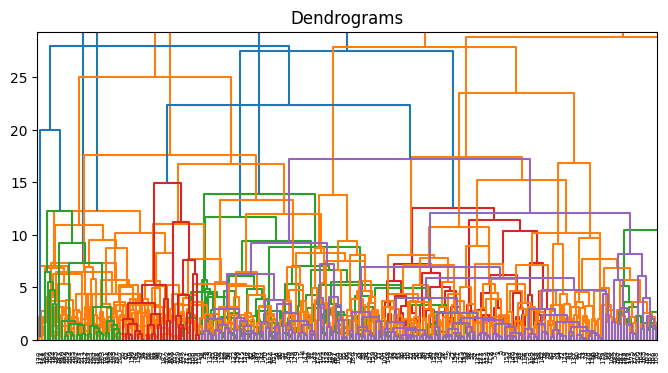

In [29]:
plt.figure(figsize= (8, 4))
plt.title("Dendrograms")
dend_wine = shc.dendrogram(shc.linkage (X_wine, method='ward'))
dend_iris = shc.dendrogram(shc.linkage (X_iris, method='ward'))
dend_landsat = shc.dendrogram(shc.linkage (X_landsat, method='ward'))
dend_magic = shc.dendrogram(shc.linkage (X_magic, method='ward'))
dend_glass = shc.dendrogram(shc.linkage (X_glass, method='ward'))

In [30]:
unique_colors_wine = set(dend_wine['color_list'])
unique_colors_iris = set(dend_iris['color_list'])
unique_colors_landsat = set(dend_landsat['color_list'])
unique_colors_magic = set(dend_magic['color_list'])
unique_colors_glass = set(dend_glass['color_list'])

In [31]:
optimal_number_of_clusters = len(unique_colors_wine) - 1
print(f'The optimal number of clusters wine: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_iris) - 1
print(f'The optimal number of clusters iris: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_landsat) - 1
print(f'The optimal number of clusters landsat: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_magic) - 1
print(f'The optimal number of clusters magic: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_glass) - 1
print(f'The optimal number of clusters glass: {optimal_number_of_clusters}')

The optimal number of clusters wine: 3
The optimal number of clusters iris: 2
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 2
The optimal number of clusters glass: 4


# Elbow auto

In [32]:
def elbow_second_derivative(X, K_max=10):
    inertias = []
    for k in range(1, K_max+2):
        kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
        inertias.append(kmeans.inertia_)

    second_derivative = [0] * (K_max - 1)
    for i in range(1, K_max):
        second_derivative[i-1] = inertias[i+1] + inertias[i-1] - 2 * inertias[i]

    optimal_k = np.argmax(second_derivative) + 2
    return optimal_k


In [33]:
print('The optimal number of clusters wine:',elbow_second_derivative(X_wine))

print('The optimal number of clusters iris:',elbow_second_derivative(X_iris))

print('The optimal number of clusters landsat:',elbow_second_derivative(X_landsat))

print('The optimal number of clusters magic:',elbow_second_derivative(X_magic))

print('The optimal number of clusters glass:',elbow_second_derivative(X_glass))

The optimal number of clusters wine: 3
The optimal number of clusters iris: 2
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 2
The optimal number of clusters glass: 3


# Elbow

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(X, dataset_name):
    inertia = []
    clusters = range(1, 11)

    for n in clusters:
        kmeans = KMeans(n_clusters=n, random_state=1, n_init=10).fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(6, 6))
    plt.plot(clusters, inertia, '-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {dataset_name}')
    plt.grid(True)
    plt.show()


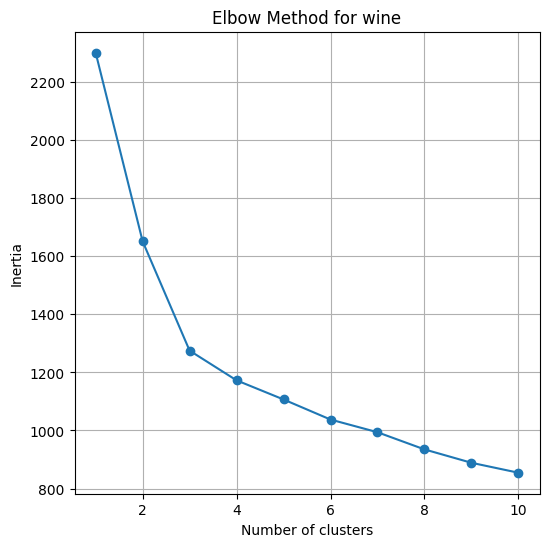

The optimal number of clusters wine: 


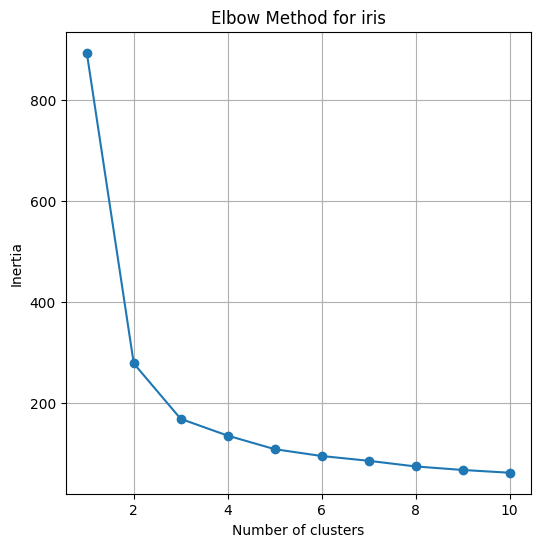

The optimal number of clusters iris: 


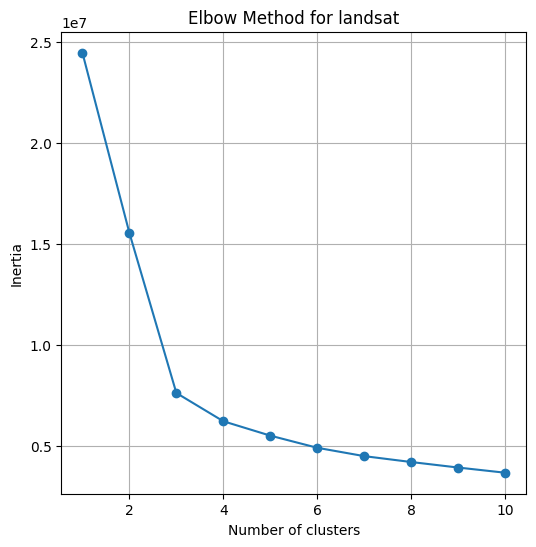

The optimal number of clusters landsat: 


In [35]:
elbow_method(X_wine, 'wine')
print("The optimal number of clusters wine: ")

elbow_method(X_iris, 'iris')
print("The optimal number of clusters iris: ")

elbow_method(data_landsat, 'landsat')
print("The optimal number of clusters landsat: ")

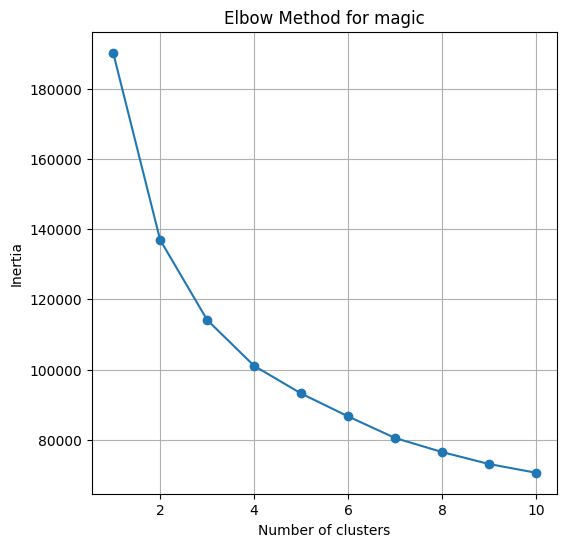

The optimal number of clusters magic: 


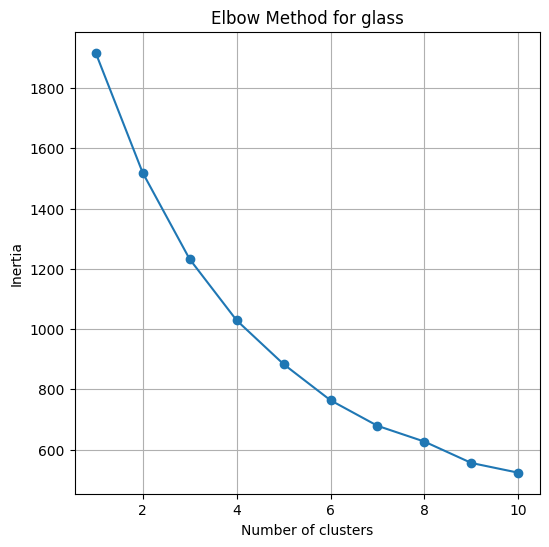

The optimal number of clusters glass: 


In [36]:
elbow_method(X_magic, 'magic')
print("The optimal number of clusters magic: ")

elbow_method(X_glass, 'glass')
print("The optimal number of clusters glass: ")

# DeD Method

In [37]:
def depth(point, data):
    return np.mean(np.linalg.norm(data - point, axis=1))

def data_depth(X, k_range=None, n_init=50):
    # Normalize the data
    #X = StandardScaler().fit_transform(X)

    # Set default k_range based on the size of the dataset
    if k_range is None:
        k_range = (2, int(np.sqrt(X.shape[0] / 2)))
    
    n = len(X)
    depths = np.array([depth(x, X) for x in X])
    median_depth = np.median(depths)
    A = np.mean(np.abs(depths - median_depth))

    DeD_scores = []

    for k in range(*k_range):
        clusterer = KMeans(n_clusters=k, n_init=n_init).fit(X)
        labels = clusterer.labels_
        cluster_As = []
        for i in range(k):
            cluster_points = X[labels == i]
            cluster_depths = np.array([depth(x, cluster_points) for x in cluster_points])
            cluster_median_depth = np.median(cluster_depths)
            cluster_As.append(np.mean(np.abs(cluster_depths - cluster_median_depth)))
        DW = np.mean(cluster_As)
        DB = A - DW

        # Change the evaluation to division instead of subtraction
        # Add a small constant in the denominator to avoid division by zero
        DeD = DW - DB
        DeD_scores.append(DeD)

    optimal_clusters = np.argmax(DeD_scores) + k_range[0]

    return optimal_clusters

In [ ]:
optimal_clusters = data_depth(X_wine)
print(f"The optimal number of clusters wine {optimal_clusters}")

optimal_clusters = data_depth(X_iris)
print(f"The optimal number of clusters iris {optimal_clusters}")

optimal_clusters = data_depth(X_landsat)
print(f"The optimal number of clusters landsat {optimal_clusters}")

optimal_clusters = data_depth(X_magic)
print(f"The optimal number of clusters magic {optimal_clusters}")

optimal_clusters = data_depth(X_glass)
print(f"The optimal number of clusters glass {optimal_clusters}")

The optimal number of clusters wine 2
The optimal number of clusters iris 2
The optimal number of clusters landsat 2


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


# Silhouette Algorithm

In [117]:
def optimal_clusters_via_silhouette(data, max_clusters=10):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)

        labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

    best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    
    return best_n_clusters


In [118]:
best_n_clusters = optimal_clusters_via_silhouette(X_wine, max_clusters=10)
print(f"The optimal number of clusters wine {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_iris, max_clusters=10)
print(f"The optimal number of clusters wine {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_landsat, max_clusters=10)
print(f"The optimal number of clusters wine {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_magic, max_clusters=10)
print(f"The optimal number of clusters wine {best_n_clusters}")

best_n_clusters = optimal_clusters_via_silhouette(X_glass, max_clusters=10)
print(f"The optimal number of clusters wine {best_n_clusters}")

The optimal number of clusters wine 3
The optimal number of clusters wine 2
The optimal number of clusters wine 3
The optimal number of clusters wine 2
The optimal number of clusters wine 2


---

# Clustering

In [37]:
def perform_kmeans_clustering(X, K):
    kmeans = KMeans(n_clusters=K, random_state=0)

    kmeans.fit(X)

    return kmeans.labels_


In [189]:
dbi_sum = []
dunn_sum = []
silhouette_sum = []

### Ratio of variance

In [190]:
labels_row_wine = perform_kmeans_clustering(X_wine, 3)
labels_row_iris = perform_kmeans_clustering(X_iris, 2)
labels_row_landsat = perform_kmeans_clustering(X_landsat, 6)
labels_row_magic = perform_kmeans_clustering(X_magic, 13)
labels_row_glass = perform_kmeans_clustering(X_glass, 4)

##### Davies-Bouldin

In [191]:
dbi_row_wine = davies_bouldin_score(X_wine, labels_row_wine)
dbi_row_iris = davies_bouldin_score(X_iris, labels_row_iris)
dbi_row_landsat = davies_bouldin_score(X_landsat, labels_row_landsat)
dbi_row_magic = davies_bouldin_score(X_magic, labels_row_magic)
dbi_row_glass = davies_bouldin_score(X_glass, labels_row_glass)

In [192]:
print('dbi wine', dbi_row_wine)
print('dbi iris', dbi_row_iris)
print('dbi landsat', dbi_row_landsat)
print('dbi magic', dbi_row_magic)
print('dbi glass', dbi_row_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975417
dbi landsat 1.0305703566701483
dbi magic 1.476887298560113
dbi glass 1.068854970613817


In [193]:
dbi_sum_row = dbi_row_wine + dbi_row_iris + dbi_row_landsat + dbi_row_magic + dbi_row_glass
dbi_sum.append(dbi_sum_row)

##### Dunn

In [194]:
from scipy.spatial.distance import cdist

def calculate_dunn(features, labels):
    unique_clusters = np.unique(labels)

    inter_cluster_distances = []
    intra_cluster_distances = []

    for cluster in unique_clusters:
        intra_cluster_points = features[labels == cluster]
        intra_cluster_distances.append(np.max(cdist(intra_cluster_points, intra_cluster_points)))

        for other_cluster in unique_clusters:
            if cluster != other_cluster:
                inter_cluster_points = features[labels == other_cluster]
                inter_cluster_distances.append(np.min(cdist(intra_cluster_points, inter_cluster_points)))

    dunn_index = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    return dunn_index


In [195]:
dunn_row_wine = calculate_dunn(X_wine, labels_row_wine)
dunn_row_iris = calculate_dunn(X_iris, labels_row_iris)
dunn_row_landsat = calculate_dunn(X_landsat, labels_row_landsat)
dunn_row_magic = calculate_dunn(X_magic, labels_row_magic)
dunn_row_glass = calculate_dunn(X_glass, labels_row_glass)

In [196]:
print('dunn wine', dunn_row_wine)
print('dunn iris', dunn_row_iris)
print('dunn landsat', dunn_row_landsat)
print('dunn magic', dunn_row_magic)
print('dunn glass', dunn_row_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.06402402144510183
dunn magic 0.012089204950848044
dunn glass 0.06803737521741275


In [197]:
dunn_sum_row = dunn_row_wine + dunn_row_iris + dunn_row_landsat + dunn_row_magic + dunn_row_glass
dunn_sum.append(dunn_sum_row)

##### Silhuette

In [198]:
silhouette_row_wine = silhouette_score(X_wine, labels_row_wine)
silhouette_row_iris = silhouette_score(X_iris, labels_row_iris)
silhouette_row_landsat = silhouette_score(X_landsat, labels_row_landsat)
silhouette_row_magic = silhouette_score(X_magic, labels_row_magic)
silhouette_row_glass = silhouette_score(X_glass, labels_row_glass)

In [199]:
print('silhouette wine', silhouette_row_wine)
print('silhouette iris', silhouette_row_iris)
print('silhouette landsat', silhouette_row_landsat)
print('silhouette magic', silhouette_row_magic)
print('silhouette glass', silhouette_row_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.34954712654478576
silhouette magic 0.16306897530164735
silhouette glass 0.39274670829836283


In [200]:
silhouette_sum_row = silhouette_row_wine + silhouette_row_iris + silhouette_row_landsat + silhouette_row_magic + silhouette_row_glass
silhouette_sum.append(silhouette_sum_row)

### Agglomerative clustering method

In [201]:
labels_aggl_wine = perform_kmeans_clustering(X_wine, 3)
labels_aggl_iris = perform_kmeans_clustering(X_iris, 2)
labels_aggl_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_aggl_magic = perform_kmeans_clustering(X_magic, 2)
labels_aggl_glass = perform_kmeans_clustering(X_glass, 4)

##### Davies-Bouldin

In [202]:
dbi_aggl_wine = davies_bouldin_score(X_wine, labels_aggl_wine)
dbi_aggl_iris = davies_bouldin_score(X_iris, labels_aggl_iris)
dbi_aggl_landsat = davies_bouldin_score(X_landsat, labels_aggl_landsat)
dbi_aggl_magic = davies_bouldin_score(X_magic, labels_aggl_magic)
dbi_aggl_glass = davies_bouldin_score(X_glass, labels_aggl_glass)

In [203]:
print('dbi wine', dbi_aggl_wine)
print('dbi iris', dbi_aggl_iris)
print('dbi landsat', dbi_aggl_landsat)
print('dbi magic', dbi_aggl_magic)
print('dbi glass', dbi_aggl_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975417
dbi landsat 0.8063377004758395
dbi magic 1.4400482703184725
dbi glass 1.068854970613817


In [204]:
dbi_sum_aggl = dbi_aggl_wine + dbi_aggl_iris + dbi_aggl_landsat + dbi_aggl_magic + dbi_aggl_glass
dbi_sum.append(dbi_sum_aggl)

##### Dunn

In [205]:
dunn_aggl_wine = calculate_dunn(X_wine, labels_aggl_wine)
dunn_aggl_iris = calculate_dunn(X_iris, labels_aggl_iris)
dunn_aggl_landsat = calculate_dunn(X_landsat, labels_aggl_landsat)
dunn_aggl_magic = calculate_dunn(X_magic, labels_aggl_magic)
dunn_aggl_glass = calculate_dunn(X_glass, labels_aggl_glass)

In [206]:
print('dunn wine', dunn_aggl_wine)
print('dunn iris', dunn_aggl_iris)
print('dunn landsat', dunn_aggl_landsat)
print('dunn magic', dunn_aggl_magic)
print('dunn glass', dunn_aggl_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.06803737521741275


In [207]:
dunn_sum_aggl = dunn_aggl_wine + dunn_aggl_iris + dunn_aggl_landsat + dunn_aggl_magic + dunn_aggl_glass
dunn_sum.append(dunn_sum_aggl)

###### Silhouette

In [208]:
silhouette_aggl_wine = silhouette_score(X_wine, labels_aggl_wine)
silhouette_aggl_iris = silhouette_score(X_iris, labels_aggl_iris)
silhouette_aggl_landsat = silhouette_score(X_landsat, labels_aggl_landsat)
silhouette_aggl_magic = silhouette_score(X_magic, labels_aggl_magic)
silhouette_aggl_glass = silhouette_score(X_glass, labels_aggl_glass)

In [209]:
print('silhouette wine', silhouette_aggl_wine)
print('silhouette iris', silhouette_aggl_iris)
print('silhouette landsat', silhouette_aggl_landsat)
print('silhouette magic', silhouette_aggl_magic)
print('silhouette glass', silhouette_aggl_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220625
silhouette magic 0.29398016082014095
silhouette glass 0.39274670829836283


In [210]:
silhouette_sum_aggl = silhouette_aggl_wine + silhouette_aggl_iris + silhouette_aggl_landsat + silhouette_aggl_magic + silhouette_aggl_glass
silhouette_sum.append(silhouette_sum_aggl)

### HSE

In [211]:
labels_hse_wine = perform_kmeans_clustering(X_wine, 7)
labels_hse_iris = perform_kmeans_clustering(X_iris, 3)
labels_hse_landsat = perform_kmeans_clustering(X_landsat, 14)
labels_hse_magic = perform_kmeans_clustering(X_magic, 6)
labels_hse_glass = perform_kmeans_clustering(X_glass, 8)

##### Davies-Bouldin

In [212]:
dbi_hse_wine = davies_bouldin_score(X_wine, labels_hse_wine)
dbi_hse_iris = davies_bouldin_score(X_iris, labels_hse_iris)
dbi_hse_landsat = davies_bouldin_score(X_landsat, labels_hse_landsat)
dbi_hse_magic = davies_bouldin_score(X_magic, labels_hse_magic)
dbi_hse_glass = davies_bouldin_score(X_glass, labels_hse_glass)

In [213]:
print('dbi wine', dbi_hse_wine)
print('dbi iris', dbi_hse_iris)
print('dbi landsat', dbi_hse_landsat)
print('dbi magic', dbi_hse_magic)
print('dbi glass', dbi_hse_glass)

dbi wine 1.8423550987842372
dbi iris 0.790337349724394
dbi landsat 1.363802081175187
dbi magic 1.5231232892625706
dbi glass 1.0203767302176345


In [214]:
dbi_sum_hse = dbi_hse_wine + dbi_hse_iris + dbi_hse_landsat + dbi_hse_magic + dbi_hse_glass
dbi_sum.append(dbi_sum_hse)

##### Dunn

In [215]:
dunn_hse_wine = calculate_dunn(X_wine, labels_hse_wine)
dunn_hse_iris = calculate_dunn(X_iris, labels_hse_iris)
dunn_hse_landsat = calculate_dunn(X_landsat, labels_hse_landsat)
dunn_hse_magic = calculate_dunn(X_magic, labels_hse_magic)
dunn_hse_glass = calculate_dunn(X_glass, labels_hse_glass)

In [216]:
print('dunn wine', dunn_hse_wine)
print('dunn iris', dunn_hse_iris)
print('dunn landsat', dunn_hse_landsat)
print('dunn magic', dunn_hse_magic)
print('dunn glass', dunn_hse_glass)

dunn wine 0.16822402134466644
dunn iris 0.05728744899435519
dunn landsat 0.07957980579412446
dunn magic 0.009081042368871473
dunn glass 0.06685850684842645


In [217]:
dunn_sum_hse = dunn_hse_wine + dunn_hse_iris + dunn_hse_landsat + dunn_hse_magic + dunn_hse_glass
dunn_sum.append(dunn_sum_hse)

##### Silhouette

In [218]:
silhouette_hse_wine = silhouette_score(X_wine, labels_hse_wine)
silhouette_hse_iris = silhouette_score(X_iris, labels_hse_iris)
silhouette_hse_landsat = silhouette_score(X_landsat, labels_hse_landsat)
silhouette_hse_magic = silhouette_score(X_magic, labels_hse_magic)
silhouette_hse_glass = silhouette_score(X_glass, labels_hse_glass)

In [219]:
print('silhouette wine', silhouette_hse_wine)
print('silhouette iris', silhouette_hse_iris)
print('silhouette landsat', silhouette_hse_landsat)
print('silhouette magic', silhouette_hse_magic)
print('silhouette glass', silhouette_hse_glass)

silhouette wine 0.1614693242425343
silhouette iris 0.4868348099424627
silhouette landsat 0.23974784073905667
silhouette magic 0.2018731671110055
silhouette glass 0.35721602294522736


In [220]:
silhouette_sum_hse = silhouette_hse_wine + silhouette_hse_iris + silhouette_hse_landsat + silhouette_hse_magic + silhouette_hse_glass
silhouette_sum.append(silhouette_sum_hse)

### Gaussian

In [221]:
labels_gaus_wine = perform_kmeans_clustering(X_wine, 3)
labels_gaus_iris = perform_kmeans_clustering(X_iris, 9)
labels_gaus_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_gaus_magic = perform_kmeans_clustering(X_magic, 3)
labels_gaus_glass = perform_kmeans_clustering(X_glass, 5)

##### Davies-Bouldin

In [222]:
dbi_gaus_wine = davies_bouldin_score(X_wine, labels_gaus_wine)
dbi_gaus_iris = davies_bouldin_score(X_iris, labels_gaus_iris)
dbi_gaus_landsat = davies_bouldin_score(X_landsat, labels_gaus_landsat)
dbi_gaus_magic = davies_bouldin_score(X_magic, labels_gaus_magic)
dbi_gaus_glass = davies_bouldin_score(X_glass, labels_gaus_glass)

In [223]:
print('dbi wine', dbi_gaus_wine)
print('dbi iris', dbi_gaus_iris)
print('dbi landsat', dbi_gaus_landsat)
print('dbi magic', dbi_gaus_magic)
print('dbi glass', dbi_gaus_glass)

dbi wine 1.3938085497845032
dbi iris 1.0231425876475893
dbi landsat 0.8063377004758395
dbi magic 1.4414681669180496
dbi glass 1.0362157732353705


In [224]:
dbi_sum_gaus = dbi_gaus_wine + dbi_gaus_iris + dbi_gaus_landsat + dbi_gaus_magic + dbi_gaus_glass
dbi_sum.append(dbi_sum_gaus)

##### Dunn

In [225]:
dunn_gaus_wine = calculate_dunn(X_wine, labels_gaus_wine)
dunn_gaus_iris = calculate_dunn(X_iris, labels_gaus_iris)
dunn_gaus_landsat = calculate_dunn(X_landsat, labels_gaus_landsat)
dunn_gaus_magic = calculate_dunn(X_magic, labels_gaus_magic)
dunn_gaus_glass = calculate_dunn(X_glass, labels_gaus_glass)

In [226]:
print('dunn wine', dunn_gaus_wine)
print('dunn iris', dunn_gaus_iris)
print('dunn landsat', dunn_gaus_landsat)
print('dunn magic', dunn_gaus_magic)
print('dunn glass', dunn_gaus_glass)

dunn wine 0.23255059257771643
dunn iris 0.08432649214397495
dunn landsat 0.07868192652086056
dunn magic 0.010466874735399924
dunn glass 0.046607434978379346


In [227]:
dunn_sum_gaus = dunn_gaus_wine + dunn_gaus_iris + dunn_gaus_landsat + dunn_gaus_magic + dunn_gaus_glass
dunn_sum.append(dunn_sum_gaus)

##### Silhouette

In [228]:
silhouette_gaus_wine = silhouette_score(X_wine, labels_gaus_wine)
silhouette_gaus_iris = silhouette_score(X_iris, labels_gaus_iris)
silhouette_gaus_landsat = silhouette_score(X_landsat, labels_gaus_landsat)
silhouette_gaus_magic = silhouette_score(X_magic, labels_gaus_magic)
silhouette_gaus_glass = silhouette_score(X_glass, labels_gaus_glass)

In [229]:
print('silhouette wine', silhouette_gaus_wine)
print('silhouette iris', silhouette_gaus_iris)
print('silhouette landsat', silhouette_gaus_landsat)
print('silhouette magic', silhouette_gaus_magic)
print('silhouette glass', silhouette_gaus_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.32019284003962406
silhouette landsat 0.4361899401220625
silhouette magic 0.2707547833380507
silhouette glass 0.33656523071967764


In [230]:
silhouette_sum_gaus = silhouette_gaus_wine + silhouette_gaus_iris + silhouette_gaus_landsat + silhouette_gaus_magic + silhouette_gaus_glass
silhouette_sum.append(silhouette_sum_gaus)

### DeD

In [231]:
labels_ded_wine = perform_kmeans_clustering(X_wine, 5)
labels_ded_iris = perform_kmeans_clustering(X_iris, 2)
labels_ded_landsat = perform_kmeans_clustering(X_landsat, 2)
labels_ded_magic = perform_kmeans_clustering(X_magic, 2)
labels_ded_glass = perform_kmeans_clustering(X_glass, 2)

##### Davies-Bouldin

In [232]:
dbi_ded_wine = davies_bouldin_score(X_wine, labels_ded_wine)
dbi_ded_iris = davies_bouldin_score(X_iris, labels_ded_iris)
dbi_ded_landsat = davies_bouldin_score(X_landsat, labels_ded_landsat)
dbi_ded_magic = davies_bouldin_score(X_magic, labels_ded_magic)
dbi_ded_glass = davies_bouldin_score(X_glass, labels_ded_glass)

In [233]:
print('dbi wine', dbi_ded_wine)
print('dbi iris', dbi_ded_iris)
print('dbi landsat', dbi_ded_landsat)
print('dbi magic', dbi_ded_magic)
print('dbi glass', dbi_ded_glass)

dbi wine 1.654522439913134
dbi iris 0.5135579403975417
dbi landsat 1.2265837953863246
dbi magic 1.4400482703184725
dbi glass 1.2536470953739458


In [234]:
dbi_sum_ded = dbi_ded_wine + dbi_ded_iris + dbi_ded_landsat + dbi_ded_magic + dbi_ded_glass
dbi_sum.append(dbi_sum_ded)

##### Dunn

In [235]:
dunn_ded_wine = calculate_dunn(X_wine, labels_ded_wine)
dunn_ded_iris = calculate_dunn(X_iris, labels_ded_iris)
dunn_ded_landsat = calculate_dunn(X_landsat, labels_ded_landsat)
dunn_ded_magic = calculate_dunn(X_magic, labels_ded_magic)
dunn_ded_glass = calculate_dunn(X_glass, labels_ded_glass)

In [236]:
print('dunn wine', dunn_ded_wine)
print('dunn iris', dunn_ded_iris)
print('dunn landsat', dunn_ded_landsat)
print('dunn magic', dunn_ded_magic)
print('dunn glass', dunn_ded_glass)

dunn wine 0.16341077315799515
dunn iris 0.3400472974470128
dunn landsat 0.032197924065327295
dunn magic 0.0089219151508982
dunn glass 0.08567299762919413


In [237]:
dunn_sum_ded = dunn_ded_wine + dunn_ded_iris + dunn_ded_landsat + dunn_ded_magic + dunn_ded_glass
dunn_sum.append(dunn_sum_ded)

##### Silhouette

In [238]:
silhouette_ded_wine = silhouette_score(X_wine, labels_ded_wine)
silhouette_ded_iris = silhouette_score(X_iris, labels_ded_iris)
silhouette_ded_landsat = silhouette_score(X_landsat, labels_ded_landsat)
silhouette_ded_magic = silhouette_score(X_magic, labels_ded_magic)
silhouette_ded_glass = silhouette_score(X_glass, labels_ded_glass)

In [239]:
print('silhouette wine', silhouette_ded_wine)
print('silhouette iris', silhouette_ded_iris)
print('silhouette landsat', silhouette_ded_landsat)
print('silhouette magic', silhouette_ded_magic)
print('silhouette glass', silhouette_ded_glass)

silhouette wine 0.24791597855009315
silhouette iris 0.6212746008079453
silhouette landsat 0.33738577679258847
silhouette magic 0.29398016082014095
silhouette glass 0.4191005576215951


In [240]:
silhouette_sum_ded = silhouette_ded_wine + silhouette_ded_iris + silhouette_ded_landsat + silhouette_ded_magic + silhouette_ded_glass
silhouette_sum.append(silhouette_sum_ded)

### Elbow

In [241]:
labels_elbow_wine = perform_kmeans_clustering(X_wine, 3)
labels_elbow_iris = perform_kmeans_clustering(X_iris, 2)
labels_elbow_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_elbow_magic = perform_kmeans_clustering(X_magic, 2)
labels_elbow_glass = perform_kmeans_clustering(X_glass, 3)

##### Davies-Bouldin

In [242]:
dbi_elbow_wine = davies_bouldin_score(X_wine, labels_elbow_wine)
dbi_elbow_iris = davies_bouldin_score(X_iris, labels_elbow_iris)
dbi_elbow_landsat = davies_bouldin_score(X_landsat, labels_elbow_landsat)
dbi_elbow_magic = davies_bouldin_score(X_magic, labels_elbow_magic)
dbi_elbow_glass = davies_bouldin_score(X_glass, labels_elbow_glass)

In [243]:
print('dbi wine', dbi_elbow_wine)
print('dbi iris', dbi_elbow_iris)
print('dbi landsat', dbi_elbow_landsat)
print('dbi magic', dbi_elbow_magic)
print('dbi glass', dbi_elbow_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975417
dbi landsat 0.8063377004758395
dbi magic 1.4400482703184725
dbi glass 1.3815801690199292


In [244]:
dbi_sum_elbow = dbi_elbow_wine + dbi_elbow_iris + dbi_elbow_landsat + dbi_elbow_magic + dbi_elbow_glass
dbi_sum.append(dbi_sum_elbow)

##### Dunn

In [245]:
dunn_elbow_wine = calculate_dunn(X_wine, labels_elbow_wine)
dunn_elbow_iris = calculate_dunn(X_iris, labels_elbow_iris)
dunn_elbow_landsat = calculate_dunn(X_landsat, labels_elbow_landsat)
dunn_elbow_magic = calculate_dunn(X_magic, labels_elbow_magic)
dunn_elbow_glass = calculate_dunn(X_glass, labels_elbow_glass)

In [246]:
print('dunn wine', dunn_elbow_wine)
print('dunn iris', dunn_elbow_iris)
print('dunn landsat', dunn_elbow_landsat)
print('dunn magic', dunn_elbow_magic)
print('dunn glass', dunn_elbow_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.05842043313560459


In [247]:
dunn_sum_elbow = dunn_elbow_wine + dunn_elbow_iris + dunn_elbow_landsat + dunn_elbow_magic + dunn_elbow_glass
dunn_sum.append(dunn_sum_elbow)

##### Silhouette

In [248]:
silhouette_elbow_wine = silhouette_score(X_wine, labels_elbow_wine)
silhouette_elbow_iris = silhouette_score(X_iris, labels_elbow_iris)
silhouette_elbow_landsat = silhouette_score(X_landsat, labels_elbow_landsat)
silhouette_elbow_magic = silhouette_score(X_magic, labels_elbow_magic)
silhouette_elbow_glass = silhouette_score(X_glass, labels_elbow_glass)

In [249]:
print('silhouette wine', silhouette_elbow_wine)
print('silhouette iris', silhouette_elbow_iris)
print('silhouette landsat', silhouette_elbow_landsat)
print('silhouette magic', silhouette_elbow_magic)
print('silhouette glass', silhouette_elbow_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220625
silhouette magic 0.29398016082014095
silhouette glass 0.37342084927508273


In [250]:
silhouette_sum_elbow = silhouette_elbow_wine + silhouette_elbow_iris + silhouette_elbow_landsat + silhouette_elbow_magic + silhouette_elbow_glass
silhouette_sum.append(silhouette_sum_elbow)

### Silhouette

In [251]:
labels_sil_wine = perform_kmeans_clustering(X_wine, 3)
labels_sil_iris = perform_kmeans_clustering(X_iris, 2)
labels_sil_landsat = perform_kmeans_clustering(X_landsat, 3)
labels_sil_magic = perform_kmeans_clustering(X_magic, 2)
labels_sil_glass = perform_kmeans_clustering(X_glass, 2)

##### Davies-Bouldin

In [252]:
dbi_sil_wine = davies_bouldin_score(X_wine, labels_sil_wine)
dbi_sil_iris = davies_bouldin_score(X_iris, labels_sil_iris)
dbi_sil_landsat = davies_bouldin_score(X_landsat, labels_sil_landsat)
dbi_sil_magic = davies_bouldin_score(X_magic, labels_sil_magic)
dbi_sil_glass = davies_bouldin_score(X_glass, labels_sil_glass)

In [253]:
print('dbi wine', dbi_sil_wine)
print('dbi iris', dbi_sil_iris)
print('dbi landsat', dbi_sil_landsat)
print('dbi magic', dbi_sil_magic)
print('dbi glass', dbi_sil_glass)

dbi wine 1.3938085497845032
dbi iris 0.5135579403975417
dbi landsat 0.8063377004758395
dbi magic 1.4400482703184725
dbi glass 1.2536470953739458


In [254]:
dbi_sum_sil = dbi_sil_wine + dbi_sil_iris + dbi_sil_landsat + dbi_sil_magic + dbi_sil_glass
dbi_sum.append(dbi_sum_sil)

##### Dunn

In [255]:
dunn_sil_wine = calculate_dunn(X_wine, labels_sil_wine)
dunn_sil_iris = calculate_dunn(X_iris, labels_sil_iris)
dunn_sil_landsat = calculate_dunn(X_landsat, labels_sil_landsat)
dunn_sil_magic = calculate_dunn(X_magic, labels_sil_magic)
dunn_sil_glass = calculate_dunn(X_glass, labels_sil_glass)

In [256]:
print('dunn wine', dunn_sil_wine)
print('dunn iris', dunn_sil_iris)
print('dunn landsat', dunn_sil_landsat)
print('dunn magic', dunn_sil_magic)
print('dunn glass', dunn_sil_glass)

dunn wine 0.23255059257771643
dunn iris 0.3400472974470128
dunn landsat 0.07868192652086056
dunn magic 0.0089219151508982
dunn glass 0.08567299762919413


In [257]:
dunn_sum_sil = dunn_sil_wine + dunn_sil_iris + dunn_sil_landsat + dunn_sil_magic + dunn_sil_glass
dunn_sum.append(dunn_sum_sil)

##### Silhouette

In [258]:
silhouette_sil_wine = silhouette_score(X_wine, labels_sil_wine)
silhouette_sil_iris = silhouette_score(X_iris, labels_sil_iris)
silhouette_sil_landsat = silhouette_score(X_landsat, labels_sil_landsat)
silhouette_sil_magic = silhouette_score(X_magic, labels_sil_magic)
silhouette_sil_glass = silhouette_score(X_glass, labels_sil_glass)

In [259]:
print('silhouette wine', silhouette_sil_wine)
print('silhouette iris', silhouette_sil_iris)
print('silhouette landsat', silhouette_sil_landsat)
print('silhouette magic', silhouette_sil_magic)
print('silhouette glass', silhouette_sil_glass)

silhouette wine 0.2835806364948403
silhouette iris 0.6212746008079453
silhouette landsat 0.4361899401220625
silhouette magic 0.29398016082014095
silhouette glass 0.4191005576215951


In [260]:
silhouette_sum_sil = silhouette_sil_wine + silhouette_sil_iris + silhouette_sil_landsat + silhouette_sil_magic + silhouette_sil_glass
silhouette_sum.append(silhouette_sum_sil)

# Plot indexes

In [267]:
import matplotlib.pyplot as plt

def plot_comparison(davies_bouldin_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, dbi_sum, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Davies-Bouldin")
    plt.xlabel('Methods')
    plt.ylabel('Sum of davies_bouldin indexes')

    #plt.axhline(y=0, color='r', linestyle='--')
    #plt.text(0.97, 0.02, 'prefect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

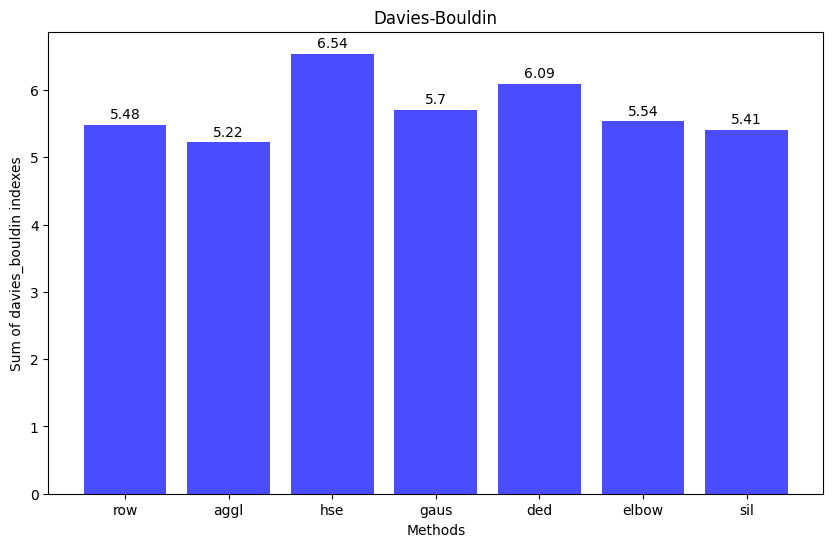

In [268]:
plot_comparison(dbi_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])

In [263]:
import matplotlib.pyplot as plt

def plot_comparison_dunn(dunn_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, dunn_sums, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Dunn")
    plt.xlabel('Methods')
    plt.ylabel('Sum of Dunn idexes')

    plt.axhline(y=5, color='r', linestyle='--')
    plt.text(0.97, 1.02, 'Perfect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

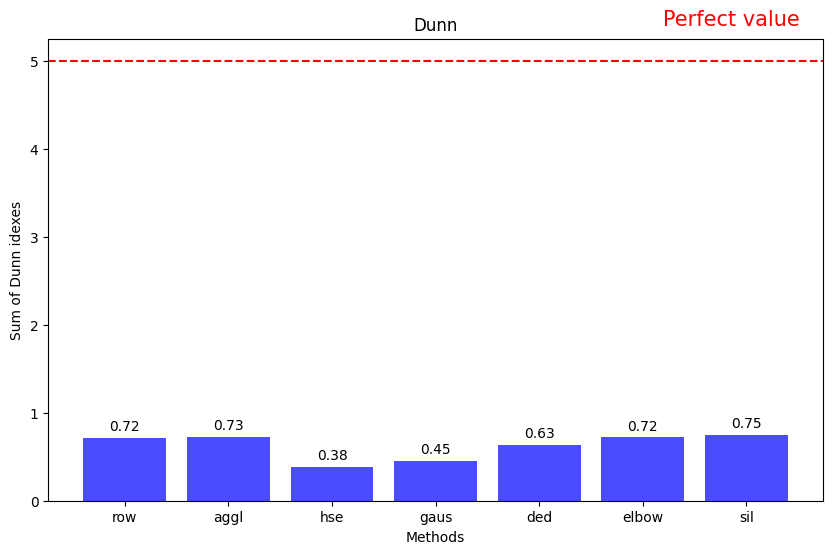

In [264]:
plot_comparison_dunn(dunn_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])

In [265]:
import matplotlib.pyplot as plt

def plot_comparison_silhouette(silhouette_sums, methods):
    plt.figure(figsize=(10,6))

    bars = plt.bar(methods, silhouette_sums, color='blue', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.title("Silhouette")
    plt.xlabel('Methods')
    plt.ylabel('Sum of Silhouette indexes')

    plt.axhline(y=5, color='r', linestyle='--')
    plt.text(0.97, 1.02, 'Perfect value', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15, transform=plt.gca().transAxes)

    plt.show()

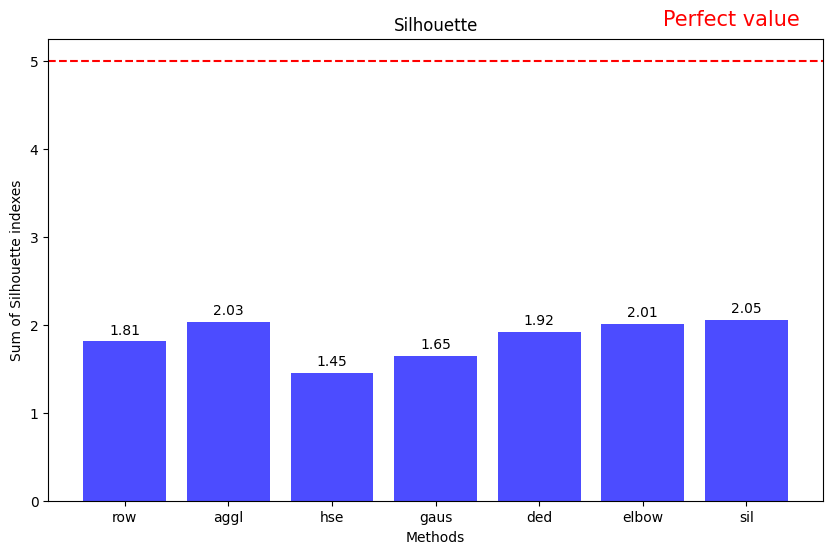

In [266]:
plot_comparison_silhouette(silhouette_sum, ['row', 'aggl', 'hse', 'gaus', 'ded', 'elbow', 'sil'])